C:\Users\krist\AppData\Local\Temp\ipykernel_21012\278419783.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='10T')


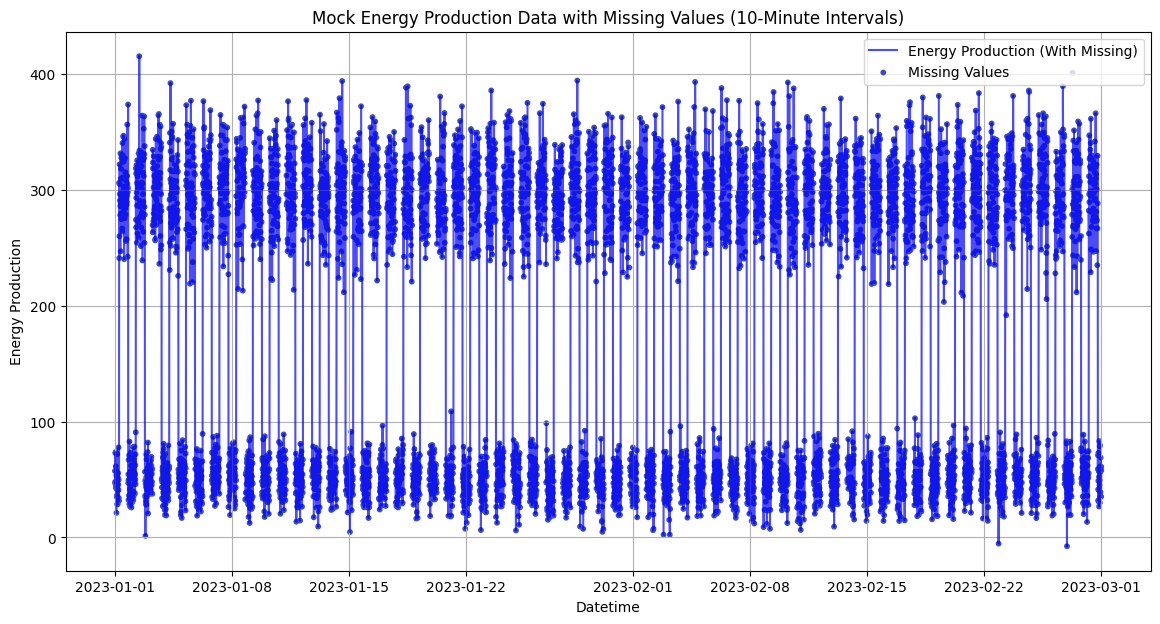

In [1]:
#Data Note: Mock Energy Production Dataset

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Generate the mock energy production data
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 3, 1)
datetime_index = pd.date_range(start=start_date, end=end_date, freq='10T')

# Create energy production values with day-night cycles
np.random.seed(42)
base_energy = []
for dt in datetime_index:
    hour = dt.hour
    if 6 <= hour <= 18:
        energy = np.random.normal(loc=300, scale=30)
    else:
        energy = np.random.normal(loc=50, scale=15)
    base_energy.append(energy)

energy_production = pd.Series(base_energy)

# Introduce missing values
num_missing = int(0.1 * len(energy_production))
missing_indices = np.random.choice(len(energy_production), num_missing, replace=False)
energy_production.iloc[missing_indices] = np.nan

mock_energy_data_with_missing = pd.DataFrame({
    'Datetime': datetime_index,
    'Energy_Production': energy_production
})

# Reset index for easier handling
data_with_index = mock_energy_data_with_missing.reset_index()
data_with_index['Time_Index'] = np.arange(len(data_with_index))  # Add time-based index

plt.figure(figsize=(14, 7))
plt.plot(mock_energy_data_with_missing['Datetime'], mock_energy_data_with_missing['Energy_Production'], 
         label='Energy Production (With Missing)', color='blue', alpha=0.7)
plt.scatter(mock_energy_data_with_missing['Datetime'], mock_energy_data_with_missing['Energy_Production'], 
            c=mock_energy_data_with_missing['Energy_Production'].isna(), cmap='coolwarm', 
            label='Missing Values', s=10)  # Reduced size of the markers
plt.title('Mock Energy Production Data with Missing Values (10-Minute Intervals)')
plt.xlabel('Datetime')
plt.ylabel('Energy Production')
plt.legend()
plt.grid(True)
plt.show()

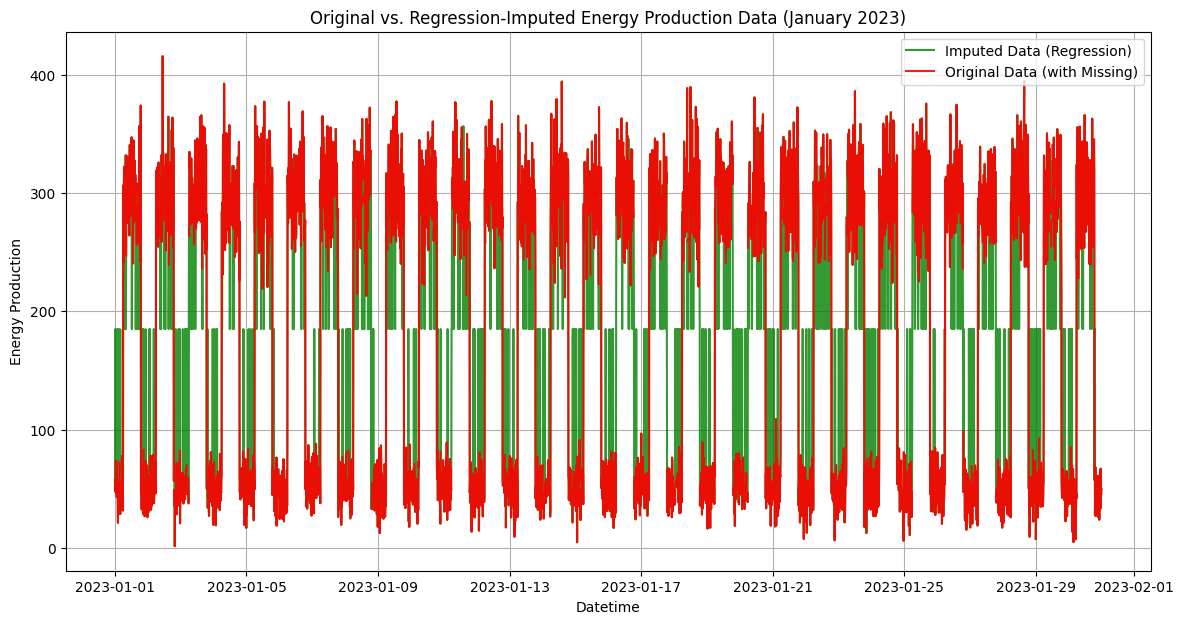

In [2]:
#Linear Regression For Time-Series Imputation

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Separate data into features (time) and target (energy production)
features = data_with_index[['Time_Index']]
target = data_with_index['Energy_Production']

# Identify missing and non-missing data
non_missing_data = data_with_index.dropna(subset=['Energy_Production'])
missing_data = data_with_index[data_with_index['Energy_Production'].isna()]

# Fit a regression model to predict the energy production
regressor = LinearRegression()
regressor.fit(non_missing_data[['Time_Index']], non_missing_data['Energy_Production'])

# Predict missing values
predicted_values = regressor.predict(missing_data[['Time_Index']])

# Fill in the missing values in the original dataset
filled_data = data_with_index.copy()
filled_data.loc[filled_data['Energy_Production'].isna(), 'Energy_Production'] = predicted_values

# Display the imputed data
filled_data = filled_data[['Datetime', 'Energy_Production']]

# Plot original vs imputed data for one month (January 2023)
start_month = datetime(2023, 1, 1)
end_month = datetime(2023, 1, 31)
original_month_data = mock_energy_data_with_missing[
    (mock_energy_data_with_missing['Datetime'] >= start_month) & 
    (mock_energy_data_with_missing['Datetime'] <= end_month)
]
imputed_month_data = filled_data[
    (filled_data['Datetime'] >= start_month) & 
    (filled_data['Datetime'] <= end_month)
]

plt.figure(figsize=(14, 7))
plt.plot(imputed_month_data['Datetime'], imputed_month_data['Energy_Production'], 
         label='Imputed Data (Regression)', color='green', alpha=0.8)
plt.plot(original_month_data['Datetime'], original_month_data['Energy_Production'], 
         label='Original Data (with Missing)', color='red', alpha=0.9)
plt.title('Original vs. Regression-Imputed Energy Production Data (January 2023)')
plt.xlabel('Datetime')
plt.ylabel('Energy Production')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
#STATISTIC COMPARISON

from statsmodels.tsa.seasonal import seasonal_decompose

# Step 1: Statistical Comparison for Linear Regression
original_stats = mock_energy_data_with_missing['Energy_Production'].describe()
imputed_stats = filled_data['Energy_Production'].describe()

stats_comparison = pd.DataFrame({
    'Metric': original_stats.index,
    'Original Data': original_stats.values,
    'Imputed Data (Linear Regression)': imputed_stats.values
})

from IPython.display import display
display(stats_comparison)

Metric  Original Data  Imputed Data (Linear Regression)
0  count    7648.000000                       8497.000000
1   mean     185.073509                        185.073842
2    std     126.816229                        120.313162
3    min      -7.549833                         -7.549833
4    25%      51.793304                         54.186258
5    50%     256.996772                        185.197681
6    75%     302.217789                        298.324435
7    max     415.581945                        415.581945